In [2]:
import torch
import numpy as np
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

# Prepare

In [3]:
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()
print()

Downloading: "https://github.com/nvidia/DeepLearningExamples/archive/torchhub.zip" to /opt/.cache/torch/hub/torchhub.zip


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [4]:
torch.save(waveglow.state_dict(), f"./model_parameters/waveglow_official.pth")
tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tacotron2')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()
print()

Using cache found in /home/gonken2020/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


# Speech Synthesis

In [101]:
text = "Takoyaki Takoyaki tabetainaaaaaa"

In [102]:
sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
sequence = torch.from_numpy(sequence).to(device='cuda', dtype=torch.int64)

In [103]:
with torch.no_grad():
    _, mel, _, _ = tacotron2.infer(sequence)
#     a = torch.zeros(mel.shape).to("cuda")
#     a[:,:,50:] = a[:,:,50:] + 1
#     mel_cut = torch.mul(mel, a)
#     mel_cut[:,:,:50] = mel_cut[:,:,:50] + mel.min() 
    audio = waveglow.infer(mel)
#     audio_cut = waveglow.infer(mel_cut)
audio_numpy = audio[0].data.cpu().numpy()
# audio_cut_numpy = audio_cut[0].data.cpu().numpy()
rate = 22050

In [104]:
play_audio(audio_numpy, rate)
# play_audio(audio_cut_numpy, rate)

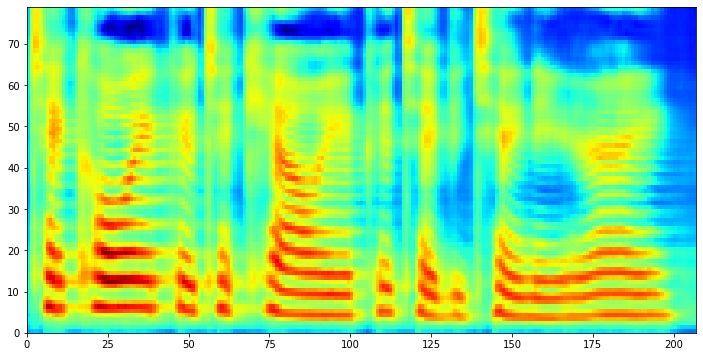

In [105]:
fig = plt.figure(figsize=(12, 6))
M = mel.detach().to("cpu").numpy()[0]
plot_spectrogram(M, fig)
# M = mel_cut.detach().to("cpu").numpy()[0]
# plot_spectrogram(np.arange(M.shape[1]), np.arange(M.shape[0]), M, fig, (1,2,2))

In [14]:
import torch

In [23]:
def generate_edge_filter(vertical=True, device="cpu", nch=3):
    edge_filter = nn.Conv2d(nch, 1, 3, 1, 1)
    parameters = edge_filter.state_dict()
    bias = torch.zeros(parameters["bias"].shape)
    parameters["bias"] = bias
    weight = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    if not vertical:
        weight = weight.T
    weight = np.tile(np.reshape(weight, (1,1,3,3)), (1,nch,1,1))
    parameters["weight"] = torch.tensor(weight)
    edge_filter.load_state_dict(parameters)
    return edge_filter.to(device)

def get_edge_filter(device="cpu", nch=3):
    return generate_edge_filter(True, device, nch), generate_edge_filter(False, device, nch)

def edge_detection(x, filter=None, device="cpu"):
    if filter==None:
        vertical_filter, horizontal_filter = get_edge_filter(device, x.shape[1])
    elif type(filter)==list:
        vertical_filter, horizontal_filter = filter
    out_ver = vertical_filter(x)
    out_hor = horizontal_filter(x)
    output = out_ver+out_hor
    return out_ver + out_hor

In [31]:
m = edge_detection(torch.tensor(np.reshape(M, (1, 1, 80, 83))))

In [34]:
m.detach().numpy()[0][0]

array([[[[-42.42752   , -27.651943  , -27.602741  , ..., -31.234657  ,
          -28.898567  ,   3.0628738 ],
         [-24.03776   ,   5.22294   ,   5.321086  , ...,   8.654329  ,
            9.759932  ,  36.652195  ],
         [-22.472694  ,   4.854046  ,   4.089901  , ...,   5.4033813 ,
            5.86011   ,  31.355282  ],
         ...,
         [-29.950397  ,   0.76575947,   1.7087145 , ...,  -0.22406864,
           -0.15378475,  37.571148  ],
         [-30.203512  ,  -0.09661436,   1.6011295 , ...,  -0.44422245,
           -0.39500618,  37.442047  ],
         [ -0.45625496,  29.80795   ,  31.05841   , ...,  37.34674   ,
           37.466526  ,  56.494328  ]]]], dtype=float32)

In [43]:
M.mean()

-0.1322437

In [44]:
M > M.mean()

array([[False, False, False, ..., False, False,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ..., False, False,  True],
       [False,  True,  True, ..., False, False,  True],
       [False,  True,  True, ...,  True,  True,  True]])

In [47]:
M

array([[-42.42752   , -27.651943  , -27.602741  , ..., -31.234657  ,
        -28.898567  ,   3.0628738 ],
       [-24.03776   ,   5.22294   ,   5.321086  , ...,   8.654329  ,
          9.759932  ,  36.652195  ],
       [-22.472694  ,   4.854046  ,   4.089901  , ...,   5.4033813 ,
          5.86011   ,  31.355282  ],
       ...,
       [-29.950397  ,   0.76575947,   1.7087145 , ...,  -0.22406864,
         -0.15378475,  37.571148  ],
       [-30.203512  ,  -0.09661436,   1.6011295 , ...,  -0.44422245,
         -0.39500618,  37.442047  ],
       [ -0.45625496,  29.80795   ,  31.05841   , ...,  37.34674   ,
         37.466526  ,  56.494328  ]], dtype=float32)

In [50]:
M.max()

56.494328

In [64]:
M.shape

(1057,)

In [ ]:
M > -3)]

In [73]:
M = mel.detach().to("cpu").numpy()[0]

In [77]:
M[M>-3].reshape(M.shape[0], -1)

ValueError: cannot reshape array of size 1057 into shape (80,newaxis)

In [ ]:
M[]

In [70]:
M>-3

array([ True,  True,  True, ...,  True,  True,  True])

In [65]:
M[np.array(M > -3)]

array([-2.9188156, -2.475921 , -2.2700295, ..., -2.832554 , -2.7790225,
       -2.9565408], dtype=float32)

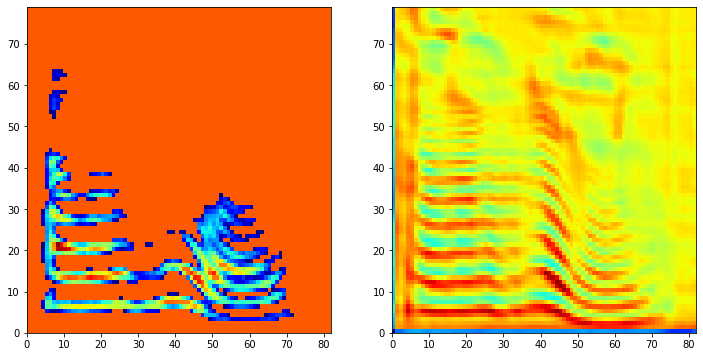

In [79]:
fig = plt.figure(figsize=(12, 6))
M = mel.detach().to("cpu").numpy()[0]
M = np.array(M > -3, np.int) * M
plot_spectrogram(M, fig, (1, 2, 1))
M = mel.detach().to("cpu").numpy()[0]
M = m.detach().numpy()[0][0]
plot_spectrogram(M, fig, (1, 2, 2))